# Introduction to the Dataset

Washington, D.C. is a city that has bike sharing stations which allow people to rent bicycles by the hour or by the day. The goal of this exploration is to compare different regression models such as LinearRegression, DecisionTreeRegressor and RandomForestRegressor to predict the # of bike rentals entry by entry. 


Hadi Fanaee-T compiled data regarding bike rentals. For the link to the data, see http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset.
We will provide descriptions for the various columns of the dataset.

1. **instant** - A unique sequential ID number for each row
2. **dteday** - The date of the rentals
3. **season** - The season in which the rentals occurred
4. **yr** - The year the rentals occurred
5. **mnth** - The month the rentals occurred
6. **hr** - The hour the rentals occurred
7. **holiday** - Whether or not the day was a holiday
8. **weekday** - The day of the week (as a number, 0 to 7)
9. **workingday** - Whether or not the day was a working day
10. **weathersit** - The weather (as a categorical variable)
11. **temp** - The temperature, on a 0-1 scale
12. **atemp** - The adjusted temperature
13. **hum** - The humidity, on a 0-1 scale
14. **windspeed** - The wind speed, on a 0-1 scale
15. **casual** - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
16. **registered** - The number of registered riders (people who had already signed up)
17. **cnt** - The total number of bike rentals (casual + registered)

Importing relevant libraries for this project:

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
from sklearn import tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

We shall also explore the data.

In [2]:
bike = pd.read_csv('bike_rental_hour.csv')
bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


To further explore 'cnt', let us create a histogram of the column alongside producing a correlation matrix of each column with cnt. 

Note to ignore 'casual' and 'registered' as they are derived from 'cnt'

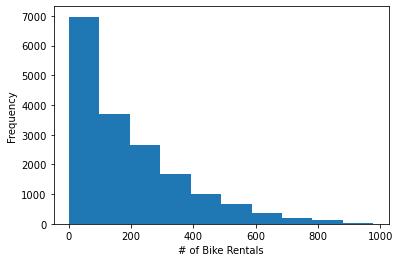

hr       0.394071
temp     0.404772
atemp    0.400929
hum     -0.322911
Name: cnt, dtype: float64


In [3]:
# Plotting histogram
plt.hist(bike['cnt'])
plt.xlabel('# of Bike Rentals')
plt.ylabel('Frequency')
plt.show()
# Creating the relevant correlation matrix as mentioned
cnt_corrs = bike.corr()['cnt']
print(cnt_corrs[(abs(cnt_corrs)>0.3)].drop(['cnt', 'casual', 'registered']))

Upon exploration we can see that 'cnt' values occur the most around the 0-200 mark, substantially dropping past that. Furthermore, we can highlight that *hr, temp, atemp, hum, casual, registered* have the highest correlations with *'cnt'*.

# Calculating Features 

Because machines don't hold value to 'hours' and 'times' in the 0-24 hour format, we need to assosciate each bike rental entry with a label that signifies time. Let us define a function that takes in the numerical hour value and returns the # interval.

* 1 for hours 6-12 
* 2 for hours 12-18
* 3 for hours 18-24 
* 4 for hours 0-6

In [101]:
def assign_label(h):
    if 6<h<=12:
        return 1 
    if 12<h<=18:
        return 2 
    if 18<h<=24: 
        return 3 
    if 0<=h<=6: 
        return 4
bike['time_label'] = bike['hr'].apply(assign_label)
# Let us now inspect the newly created column and check if we ended up w/ 
# any null values
print(bike['time_label'].head())
print(bike['time_label'].isnull().sum())

0    4
1    4
2    4
3    4
4    4
Name: time_label, dtype: int64
0


# Splitting the Data Into Train and Test Sets

Prior to splitting the data, due to the fact we will be comparing LinearRegression and DecisisionTreeRegression alongside other models, as it is a regression model, we shall use R2 score and RMSE as error metrics for points of comparison and evaluation of the machine learning models.

Let us now divide the dataset into a train and a test set via the pandas sampling method.

In [102]:
# Sampling 80% of the dataframe to be under the train set
eighty = round(bike.shape[0]*0.8)
# Sampling procedure
train = bike.sample(eighty)
# Creating a bool to index the original dataset for rows that are in 
# bike but not in train
not_in_train = bike.index.isin(train.index)
test = bike[~not_in_train]

There are also a number of other techniques to select train and test sets such as train_test_split method from sklearn.model_selection.

# Applying Linear Regression

Let us create a list of feature columns to use in training alongside the predictions. This will be every feature column above >0.1 correlation and not 'cnt, casual, dteday, registered' as they are/based on 'cnt', the output column.

In [103]:
new_corrs = train.corr()
correlated = new_corrs[(abs(new_corrs)>0.1)].drop(['cnt', 'casual', 'registered']).index
feature_columns = [col for col in correlated]

Let us now apply the linear regression model and calculate r-squared and RMSE.

In [104]:
lr = LinearRegression()
lr.fit(train[feature_columns], train['cnt'])
predictions = lr.predict(test[feature_columns])
r2_squared = r2_score(test['cnt'], predictions)
rmse = (mean_squared_error(test['cnt'], predictions))**(1/2)
print('The R_Squared value is: {:.3f}'.format(r2_squared))
print('The RMSE value is: {:.3f}'.format(rmse))

The R_Squared value is: 0.490
The RMSE value is: 129.533


The standards for a good R-Squared reading matter from subject matter. In finance, an R-Squared value of >0.7 is generally seen as positive. In scientific studies, R-squared values of >0.95 or >0.9 are required. Generally we can view the achieved R-squared value as an passable/medium fit. 

However, we can also identify our RMSE value as an indicator that this model possesses high inaccuracies.

Due to the high inaccuracy, let us shed light onto other models, such as DecisionTreeRegressor.

# Applying Decision Trees

### Decision tree regressor

In [188]:
def dt_regressor(train, test, feature_columns, msl, md): 
    '''
    The purpose of this function is to initiate, fit, and predict the R2 and RMSE values of a dataset using the Decision Tree
    Regressor algorithm.
    
    
    train: dataset containing the train values (X_train, y_train)
    test: dataset containing the test values (X_test, y_test)
    msl: value corresponding to parameter min_samples_leaf
    md: value corresponding to parameter max_depth
    '''
    dt = DecisionTreeRegressor(min_samples_leaf=msl, random_state=1, max_depth=md)
    dt.fit(train[feature_columns], train['cnt'])
    predictions_dt = dt.predict(test[feature_columns])
    r2_squared_dt = r2_score(test['cnt'], predictions_dt)
    rmse_dt = (mean_squared_error(test['cnt'], predictions_dt))**(1/2)
    return r2_squared_dt, rmse_dt
a, b = dt_regressor(train, test, feature_columns, 4, md=None)
print('The R_Squared value is: {:.3f}'.format(a))
print('The RMSE value is: {:.3f}'.format(b))

The R_Squared value is: 0.913
The RMSE value is: 53.506


In [189]:
def sensitivity_plot(parameter, ran):
    '''
    The purpose of the function is to automatically plot the RMSE and R_squared values
    given the x-range and the xlabel parameter. Below you may find the parameter labels.
    
    
    parameter: plots x_label as the given parameter label 
    ran: outlines the x-range of values in a plot
    '''
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,2)
    ax1 = plt.subplot(221)
    ax1.plot(ran, rmses_list)
    ax1.set_xlabel(parameter)
    ax1.set_ylabel('RMSE')
    ax2 = plt.subplot(222)
    ax2.plot(ran, r2_list)
    ax2.set_xlabel(parameter)
    ax2.set_ylabel('R2')
    plt.show()

### Sensitivity analysis on min_samples_leaf

Let us perform an analysis on varying the number of min_samples_leaf to see if that will have an effect of the R-squared value and RMSE value overtime: 

In [191]:
rmses_list = []
r2_list = []
for i in range(2,50):
    c, d = dt_regressor(train,test,feature_columns,i, None)
    rmses_list.append(d)
    r2_list.append(c)

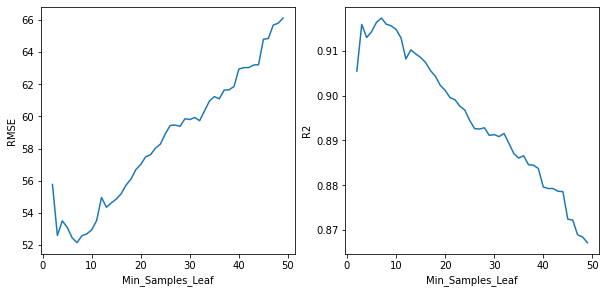

In [192]:
sensitivity_plot('Min_Samples_Leaf', range(2,50))

As far as RMSE error and R2 concerns, we can see the optimal amount being at ~6-7 min_samples leaf. Let us use this value moving forward and test for other DecisionTreeRegression parameters such as **max_depth**.

### Sensitivity Analysis on max_depth

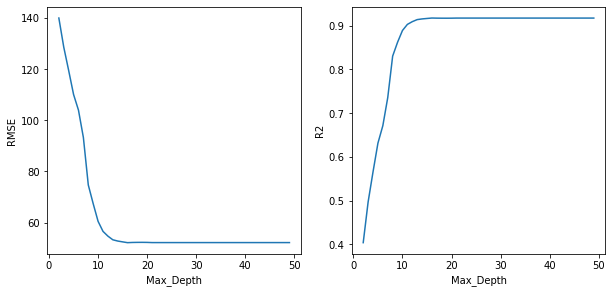

In [195]:
rmses_list = []
r2_list = []
for i in range(2,50):
    c, d = dt_regressor(train,test,feature_columns,7,i)
    rmses_list.append(d)
    r2_list.append(c)
sensitivity_plot('Max_Depth',range(2,50))

In [196]:
# Collective optimum values
a, b = dt_regressor(train, test, feature_columns, 7,13)
print('The R_Squared value is: {:.3f}'.format(a))
print('The RMSE value is: {:.3f}'.format(b))

The R_Squared value is: 0.914
The RMSE value is: 53.242


Based on above results, we can conclude the ideal max_depth is ~13 and the optimum min_samples_leaf is at ~14 as well. The reason why max_depth wouldn't be 2 or 3 is due to underfitting. If we restrict the depth of the tree too much, we increase the bias to the point where it underfits. Let us move on to apply this analysis to RandomForestRegression, which can further decrease RMSE and maximise R2.

# Applying Random Forests

### Random Forest Regression Model

The random forest algorithm is a powerful ensemble tool that may allow us to furhter minimize overfitting. 

In [218]:
def rff(train, test, feature_columns, ne, msl, md): 
    '''
    The purpose of this function is to initiate, fit, and predict the R2 and RMSE values of a dataset using the Random Forest
    Regressor algorithm.
    
    
    train: dataset containing the train values (X_train, y_train)
    test: dataset containing the test values (X_test, y_test)
    ne: value corresponding to parameter n_estimators
    msl: value corresponding to parameter min_samples_leaf
    md: value corresponding to parameter max_depth
    '''
    rf = RandomForestRegressor(n_estimators=ne, random_state=1, min_samples_leaf=msl, max_depth=md)
    rf.fit(train[feature_columns], train['cnt'])
    predictions_rf = rf.predict(test[feature_columns])
    r2_rf = r2_score(test['cnt'], predictions_rf)
    rmse_rf = (mean_squared_error(test['cnt'], predictions_rf))**(1/2)
    return r2_rf, rmse_rf
a, b = rff(train, test, feature_columns, 4, 4, None)
print('The R_Squared value is: {:.3f}'.format(a))
print('The RMSE value is: {:.3f}'.format(b))

The R_Squared value is: 0.933
The RMSE value is: 46.799


We can see a further decrease in RMSE with a substantial increase in R2 value, let us continue by varying the amount of n_estimators and then exploring the other parameters. The overall goal is to reduce RMSE below 1 and achieve R_squared to be >0.95.

### Sensitivity Analysis on n_estimators

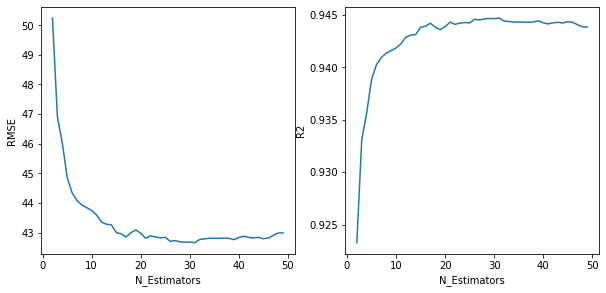

In [207]:
rmses_list = []
r2_list = []
for i in range(2,50):
    c, d = rff(train,test,feature_columns,i,2,None)
    rmses_list.append(d)
    r2_list.append(c)
sensitivity_plot('N_Estimators', range(2,50))

We can generally see that as we increase the number of estimators, the RMSE value decreases and R2 value increases signifcantly. However, we can also see a plateau tending around the 30-50 mark value. Therefore, increasing the number of estimators past this point is insignificant compared to the *increased computing time for the model to train*. To reducing processing time, let us select 30 as the optimum n_estimators while we explore other parameters.

### Sensitivity analysis on min_samples_leaf

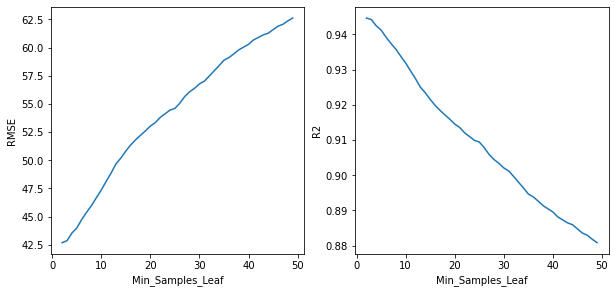

In [209]:
rmses_list = []
r2_list = []
for i in range(2,50):
    c, d = rff(train,test,feature_columns,30,i,None)
    rmses_list.append(d)
    r2_list.append(c)
sensitivity_plot('Min_Samples_Leaf', range(2,50))

We can see that increasing min_samples_leaf leads to a higher RMSE and lower R2 value, therefore showing a lower accuracy. The optimum min_samples_leaf occurs at ~3.

### Sensitivity analysis on max_depth

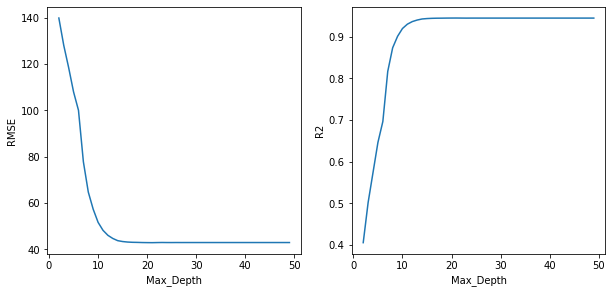

In [221]:
rmses_list = []
r2_list = []
for i in range(2,50):
    c, d = rff(train,test,feature_columns,30,3,i)
    rmses_list.append(d)
    r2_list.append(c)
sensitivity_plot('Max_Depth', range(2,50))

Similar to the previous section, we found the optimum max depth plateauing at ~14. Therefore, let us construct our final model of this project:

In [220]:
a, b = rff(train, test, feature_columns, 30,3,14)
print('The R_Squared value is: {:.3f}'.format(a))
print('The RMSE value is: {:.3f}'.format(b))

The R_Squared value is: 0.942
The RMSE value is: 43.661


# Conclusion

Although not defining the parameters in the first place will allow the algorithm to automatically select the highest accuracy parameters in the first place, it is vital to demonstrate how the relationship of the parameters relates to the accuracy of the random forest and decision tree models. 

Comparing the first model, linear regression, to the final regression model, Random Forest, we managed to increase the R2 value from 0.490 to 0.942 which is a susbtantial increase. The linear model suggests it is nto accurate enough to be implemented while the random forest model captures the predictions in a highly accurate manner. We can also see a substantial RMSE decrease from ~130 to ~42. Ideal RMSE values tend to 0 and as we weren't able to reach close to that target, we can noneteheless see a far more accurate predictions switching from linear to random forest models. 

Further steps to decrease RMSE/R2 values may lie in feature selection which can include principal component analysis, recursive feature selection, etc. Furthermore, we can also include a higher boundary cutoff for the correlations of feature columns with the target column which may improve results slightly as well. 